# INTERNET Notebook

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import average_precision_score, roc_auc_score, accuracy_score, f1_score

import optuna
import catboost as cb
import xgboost as xgb
import lightgbm as lgb


In [35]:
df = pd.read_csv('preprocessed_data/df_train_internet_only.csv')

In [36]:
df.head()

,seniorcitizen,partner,dependents,tenure,phoneservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,...,churn,is_male,internetservice_is_fiber_optic,contract_month-to-month,contract_one_year,contract_two_year,paymentmethod_bank_transfer_(automatic),paymentmethod_credit_card_(automatic),paymentmethod_electronic_check,paymentmethod_mailed_check
0,False,True,False,51.0,False,False,True,False,False,True,...,False,False,False,True,False,False,False,False,True,False
1,True,False,False,12.0,False,False,True,False,False,False,...,False,True,False,True,False,False,False,True,False,False
2,False,True,True,7.0,False,True,False,False,True,False,...,True,True,False,True,False,False,False,False,True,False
3,False,True,False,56.0,False,False,False,True,True,True,...,False,True,False,False,True,False,True,False,False,False
4,True,True,False,58.0,False,False,True,True,False,False,...,True,True,False,True,False,False,False,False,True,False


In [37]:
num_col = ['tenure', 'totalcharges', 'monthlycharges']
target = 'churn'
X_col = [c for c in df.columns if c != target]
cat_col = [c for c in X_col if c not in num_col]


Correlation with 'Churn':
churn                                      1.000000
contract_month-to-month                    0.416860
paymentmethod_electronic_check             0.246758
seniorcitizen                              0.204010
paperlessbilling                           0.157220
is_male                                    0.030796
paymentmethod_mailed_check                -0.009298
streamingmovies                           -0.024813
paymentmethod_bank_transfer_(automatic)   -0.108917
streamingtv                               -0.109068
partner                                   -0.112918
onlinebackup                              -0.152186
paymentmethod_credit_card_(automatic)     -0.163156
contract_one_year                         -0.179873
deviceprotection                          -0.184914
dependents                                -0.192869
monthlycharges                            -0.259025
onlinesecurity                            -0.275671
contract_two_year                     

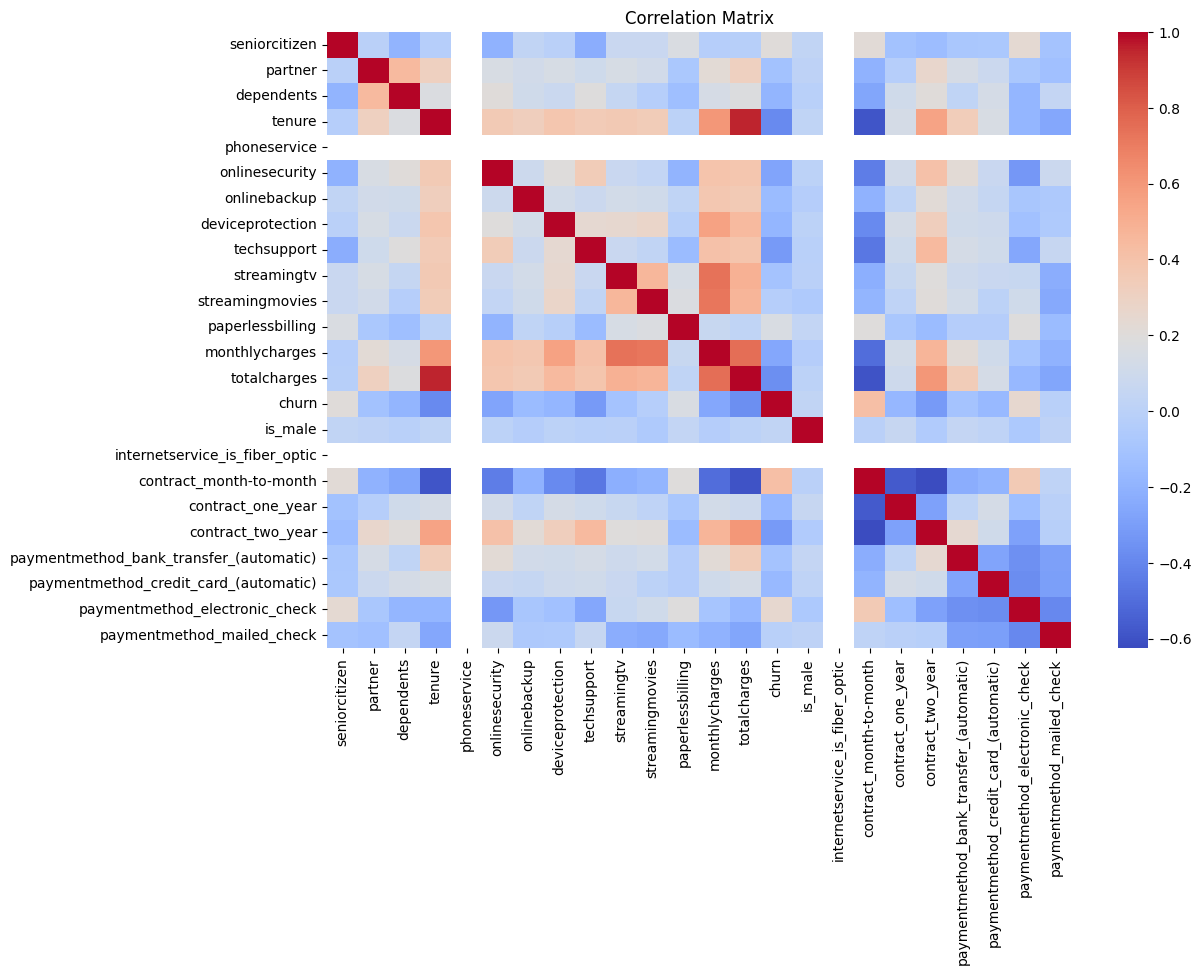

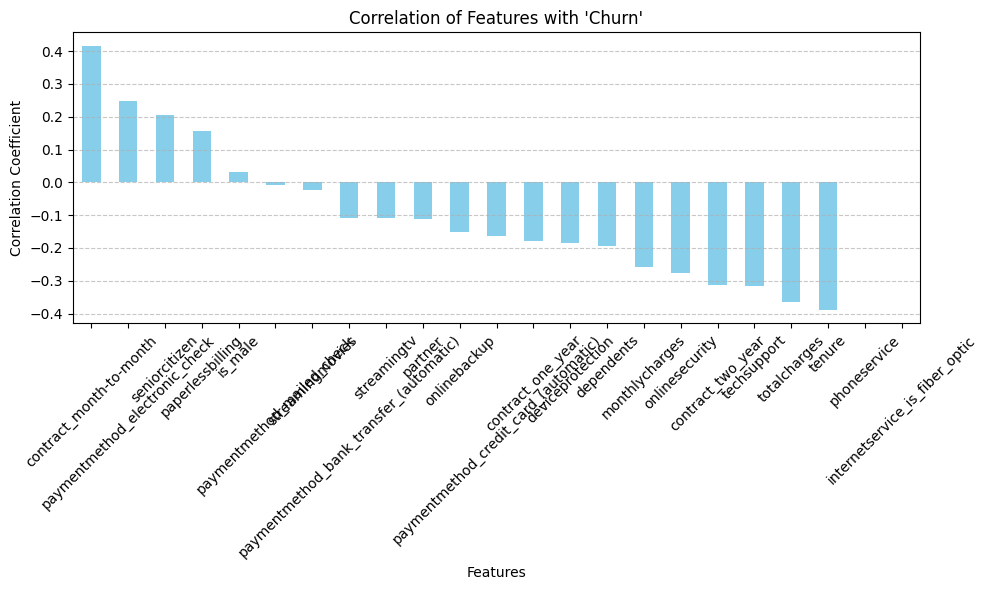

In [38]:
# Compute correlation matrix
correlation_matrix = df.corr()

# Extract correlations with 'Churn'
churn_correlation = correlation_matrix['churn'].sort_values(ascending=False)

# Print correlations
print("Correlation with 'Churn':")
print(churn_correlation)

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=False, fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

# Plot correlations with 'Churn' as a bar chart
plt.figure(figsize=(10, 6))
churn_correlation.drop('churn').plot(kind='bar', color='skyblue')
plt.title("Correlation of Features with 'Churn'")
plt.ylabel("Correlation Coefficient")
plt.xlabel("Features")
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


<Axes: xlabel='churn', ylabel='Count'>

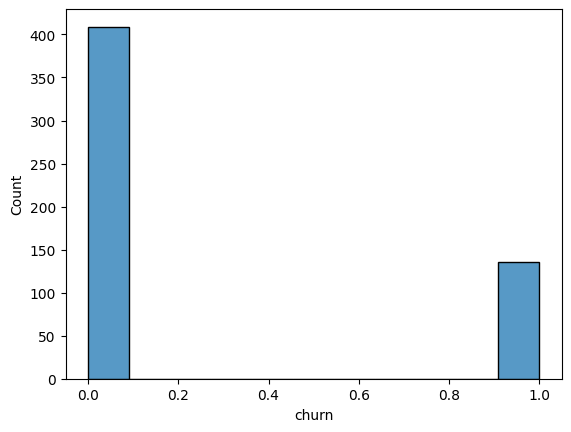

In [39]:
sns.histplot(data=df, x='churn')

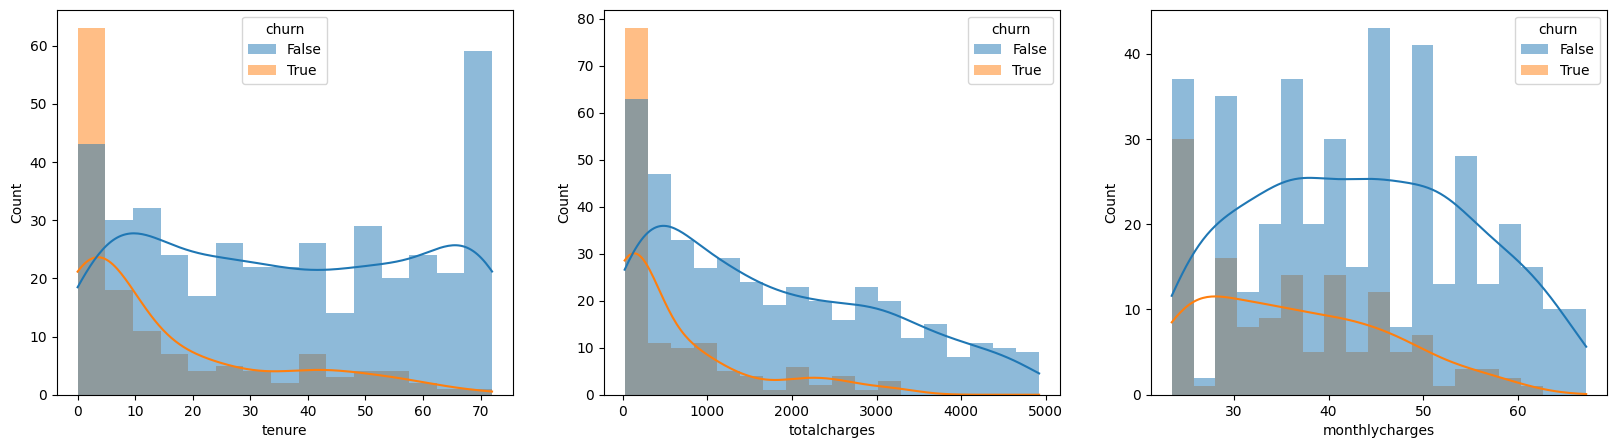

In [40]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
for col, ax in zip(num_col, axes):
    sns.histplot(
        data=df, x=col, kde=True, ax=ax, hue=target, binwidth=df[col].std() /5, edgecolor=None
    )

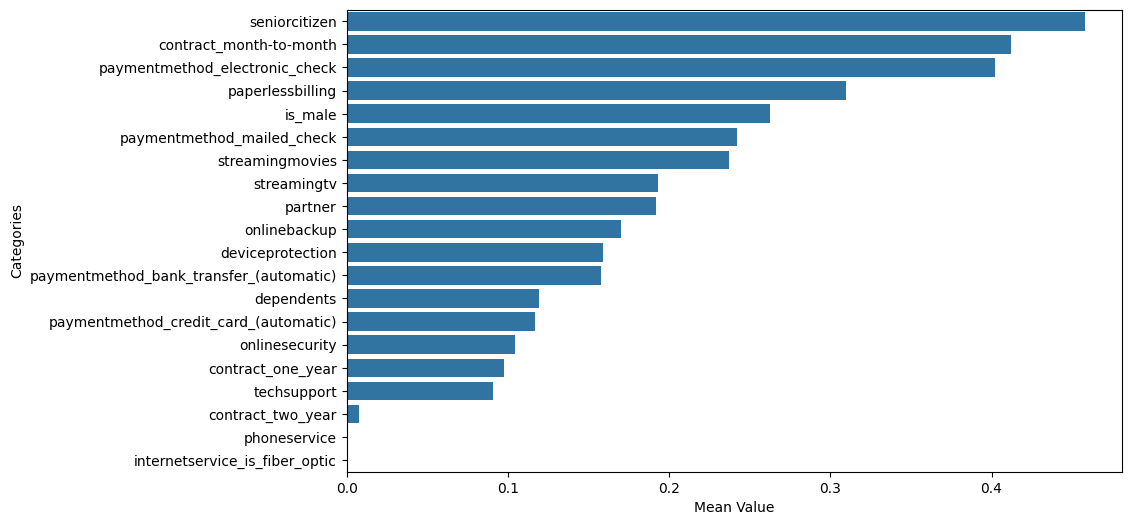

In [41]:
probability_of_churn_given_flag = df[df[target]][cat_col].sum() / df[cat_col].sum()
probability_of_churn_given_flag = probability_of_churn_given_flag.sort_values(ascending = False)

plt.figure(figsize=(10, 6))
sns.barplot(data=probability_of_churn_given_flag, orient= 'h')
plt.xlabel('Mean Value')
plt.ylabel('Categories')
plt.show()

In [42]:
scaler = RobustScaler()
df_scaled = df.copy()
df_scaled.loc[:, num_col] = scaler.fit_transform(df_scaled[num_col])

In [43]:
pca = PCA()
X_pca = pca.fit_transform(df_scaled[X_col])
importances = pca.explained_variance_ratio_ / np.sum(pca.explained_variance_ratio_)
print(pd.Series(importances)[:3])

0    0.308159
1    0.115089
2    0.061302
dtype: float64


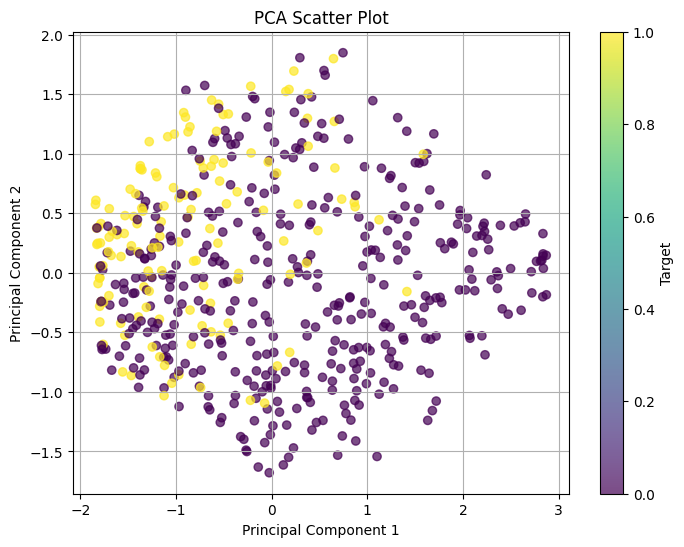

In [44]:
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df[target], cmap="viridis", alpha=0.7)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA Scatter Plot")
plt.colorbar(label="Target")
plt.grid()
plt.show()


In [45]:
fig = px.scatter_3d(
    x=X_pca[:, 0],
    y=X_pca[:, 1],
    z=X_pca[:, 2],
    color=df[target],
    labels={"x": "Principal Component 1", "y": "Principal Component 2", "z": "Principal Component 3"},
    title="3D PCA Scatter Plot",
)

fig.update_traces(marker={"size": 3})
fig.update_layout(width=1000, height=800)
fig.show()

In [46]:
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(df_scaled[X_col])

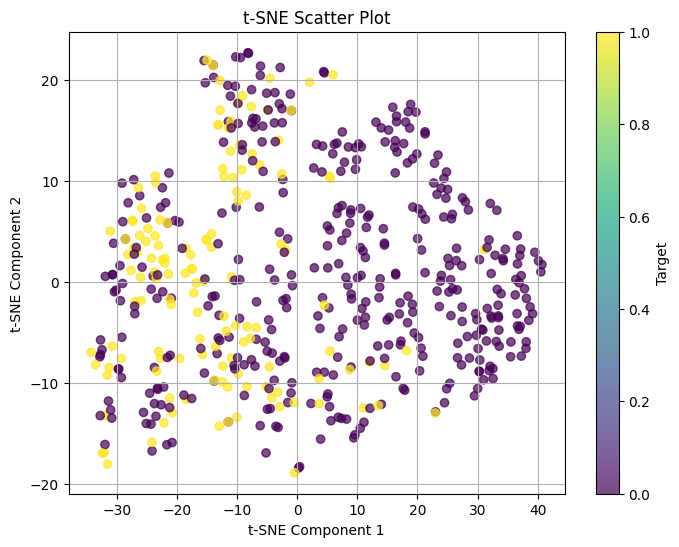

In [47]:

plt.figure(figsize=(8, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=df[target], cmap="viridis", alpha=0.7)
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.title("t-SNE Scatter Plot")
plt.colorbar(label="Target")
plt.grid()
plt.show()

## Modelling

In [48]:
X = df[X_col]
y = df[target]

In [49]:
df_test = pd.read_csv('preprocessed_data/df_test_internet_only.csv')
X_test = df_test[X_col]
y_test = df_test[target]

## CatBoost

#### Parameters research

In [50]:
def objective(trial):
    param = {
        'iterations': trial.suggest_int('iterations', 500, 1000),
        'depth': trial.suggest_int('depth', 4, 8),
        'learning_rate': trial.suggest_float('learning_rate', 1e-2, 0.1),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 16, 20),
        'subsample': trial.suggest_float('subsample', 0.4, 0.7),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 0, 5),
        'random_strength': trial.suggest_float('random_strength', 0.1, 2),
        'loss_function': 'Logloss',
        'eval_metric': 'Accuracy',
        'task_type': 'CPU',
    }

    
    kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    scores = []
    
    for train_index, valid_index in kf.split(X, y):
        X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
        y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
        
        scaler = MinMaxScaler()
        X_train.loc[:, num_col] = scaler.fit_transform(X_train[num_col])
        X_valid.loc[:, num_col] = scaler.transform(X_valid[num_col])
    
        # Create CatBoost Pool
        train_pool = cb.Pool(X_train, y_train)
        valid_pool = cb.Pool(X_valid, y_valid)
        
        # Initialize and train model
        model = cb.CatBoostClassifier(**param, 
                                      verbose=False, 
                                      early_stopping_rounds=15
                                      )
        model.fit(train_pool, 
                  eval_set=valid_pool, 
                  plot=False)
        
        # Predict and calculate accuracy
        preds = model.predict(valid_pool)
        scores.append(roc_auc_score(y_valid, preds))
    
    mean_score = np.mean(scores)
    return mean_score

# Create Optuna study
study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(seed=42),  pruner=optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=3))

# Optimize
study.optimize(objective, n_trials=20)

# Print best parameters
print("Best trial:", study.best_trial.params)

[I 2024-12-13 17:02:16,412] A new study created in memory with name: no-name-536e7c81-e4cc-43e2-ac70-934a3464b2af
[I 2024-12-13 17:02:18,032] Trial 0 finished with value: 0.6891674484052533 and parameters: {'iterations': 687, 'depth': 8, 'learning_rate': 0.07587945476302646, 'l2_leaf_reg': 18.394633936788146, 'subsample': 0.44680559213273097, 'min_data_in_leaf': 0, 'random_strength': 0.21035886311957896}. Best is trial 0 with value: 0.6891674484052533.
[I 2024-12-13 17:02:19,684] Trial 1 finished with value: 0.7100525998391851 and parameters: {'iterations': 933, 'depth': 7, 'learning_rate': 0.0737265320016441, 'l2_leaf_reg': 16.082337977183208, 'subsample': 0.6909729556485982, 'min_data_in_leaf': 4, 'random_strength': 0.5034443102887247}. Best is trial 1 with value: 0.7100525998391851.
[I 2024-12-13 17:02:21,204] Trial 2 finished with value: 0.6998207585097829 and parameters: {'iterations': 591, 'depth': 4, 'learning_rate': 0.0373818018663584, 'l2_leaf_reg': 18.09902572652895, 'subsamp

Best trial: {'iterations': 696, 'depth': 6, 'learning_rate': 0.02697449084906821, 'l2_leaf_reg': 16.92644070554812, 'subsample': 0.401622626018785, 'min_data_in_leaf': 4, 'random_strength': 1.5280655071499984}


#### Testing

In [61]:
best_params = {'iterations': 696, 'depth': 6, 'learning_rate': 0.02697449084906821, 'l2_leaf_reg': 16.92644070554812, 'subsample': 0.401622626018785, 'min_data_in_leaf': 4, 'random_strength': 1.5280655071499984}
model = cb.CatBoostClassifier(**best_params, verbose=False)
train_pool = cb.Pool(X, y)
test_pool = cb.Pool(X_test, y_test)
model.fit(train_pool)

In [62]:
print('CatBoost scores')
y_pred = model.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"RocAuc: {roc_auc_score(y_test, y_pred)}")
print(f"F1 : {f1_score(y_test, y_pred)}")

CatBoost scores
Accuracy: 0.7956204379562044
RocAuc: 0.6473443746430612
F1 : 0.46153846153846156


## XGBoost

#### Parameters research

In [53]:
def objective(trial):
    param = {
        "objective": "binary:logistic",
        "eval_metric": "aucpr",
        'n_estimators': trial.suggest_int('n_estimators', 800, 1200), 
        "booster": trial.suggest_categorical("booster", ["gbtree", "dart"]),
        "lambda": trial.suggest_float("lambda", 1e-3, 2),
        "alpha": trial.suggest_float("alpha", 1e-3, 2),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "eta": trial.suggest_float("eta", 1e-2, 0.3),
        "gamma": trial.suggest_float("gamma", 1e-3, 3),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 7),
        "subsample": trial.suggest_float("subsample", 0.6, 0.95),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 0.95),
        "grow_policy": trial.suggest_categorical(
            "grow_policy", ["depthwise", "lossguide"]
        ),
        "max_bin": trial.suggest_int("max_bin", 64, 255)
    }

    kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    scores = []
    for train_index, valid_index in kf.split(X, y):
        X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
        y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
    
        model = xgb.XGBClassifier(**param, early_stopping_rounds=15)
        model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose=False)
        preds = model.predict(X_valid)
        scores.append(accuracy_score(y_valid, preds))
    
    mean_score = np.mean(scores)   
    return mean_score

study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(seed=42), pruner=optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=3))
study.optimize(objective, n_trials=20)

print("Best trial:", study.best_trial.params)

[I 2024-12-13 17:02:51,551] A new study created in memory with name: no-name-b7c383d9-a372-489d-b4ea-4b39c2dca3e1
[I 2024-12-13 17:02:51,866] Trial 0 finished with value: 0.7560606060606061 and parameters: {'n_estimators': 950, 'booster': 'gbtree', 'lambda': 1.197718309909876, 'alpha': 0.31288126224443064, 'max_depth': 4, 'eta': 0.026844247528777843, 'gamma': 2.5986622611790304, 'min_child_weight': 5, 'subsample': 0.8478254022286159, 'colsample_bytree': 0.6072045730035308, 'grow_policy': 'depthwise', 'max_bin': 104}. Best is trial 0 with value: 0.7560606060606061.
[I 2024-12-13 17:02:52,762] Trial 1 finished with value: 0.8072390572390573 and parameters: {'n_estimators': 872, 'booster': 'dart', 'lambda': 1.0499881068328434, 'alpha': 0.8644580922655895, 'max_depth': 5, 'eta': 0.18743733946949004, 'gamma': 0.41934208809547346, 'min_child_weight': 3, 'subsample': 0.7282266451527921, 'colsample_bytree': 0.7596244944759625, 'grow_policy': 'depthwise', 'max_bin': 162}. Best is trial 1 with v

Best trial: {'n_estimators': 1037, 'booster': 'dart', 'lambda': 0.34187772325089577, 'alpha': 0.13103813437757375, 'max_depth': 10, 'eta': 0.2900332895916222, 'gamma': 2.425383647001267, 'min_child_weight': 3, 'subsample': 0.6341852399022343, 'colsample_bytree': 0.8394815592792548, 'grow_policy': 'depthwise', 'max_bin': 159}


#### Testing

In [59]:
best_params = {'n_estimators': 1037, 'booster': 'dart', 'lambda': 0.34187772325089577, 'alpha': 0.13103813437757375, 'max_depth': 10, 'eta': 0.2900332895916222, 'gamma': 2.425383647001267, 'min_child_weight': 3, 'subsample': 0.6341852399022343, 'colsample_bytree': 0.8394815592792548, 'grow_policy': 'depthwise', 'max_bin': 159}
model = xgb.XGBClassifier(**best_params)
model.fit(X, y)

XGBClassifier(alpha=0.13103813437757375, base_score=None, booster='dart',
              callbacks=None, colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8394815592792548, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eta=0.2900332895916222, eval_metric=None, feature_types=None,
              gamma=2.425383647001267, grow_policy='depthwise',
              importance_type=None, interaction_constraints=None,
              lambda=0.34187772325089577, learning_rate=None, max_bin=159,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=3, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1037, ...)

In [60]:
print('XGBoost scores')
y_pred = model.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"RocAuc: {roc_auc_score(y_test, y_pred)}")
print(f"F1 : {f1_score(y_test, y_pred)}")

XGBoost scores
Accuracy: 0.7956204379562044
RocAuc: 0.6571958880639636
F1 : 0.48148148148148145


## LGBM

#### Parameters research

In [56]:

def objective(trial):
    param = {
        'num_leaves': trial.suggest_int('num_leaves', 40, 70),
        'max_depth': trial.suggest_int('max_depth', 6, 14),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 40, 70),
        'lambda_l1': trial.suggest_float('lambda_l1', 0.1, 2),
        'lambda_l2': trial.suggest_float('lambda_l2', 0.1, 2),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.6, 0.95),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.6, 0.95),
        'bagging_freq': trial.suggest_int('bagging_freq', 5, 15),
        'boosting_type': 'gbdt',
        'objective': 'binary',
        'metric': 'binary_error',
        'n_estimators': trial.suggest_int('n_estimators', 100, 500)        
    }
    
    kf = StratifiedKFold(n_splits=20, shuffle=True, random_state=42)
    accuracies = []
    
    for train_index, valid_index in kf.split(X, y):
        X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
        y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]

        scaler = MinMaxScaler()
        X_train.loc[:, num_col] = scaler.fit_transform(X_train[num_col])
        X_valid.loc[:, num_col] = scaler.transform(X_valid[num_col])
        
        model = lgb.LGBMClassifier(**param, early_stopping_rounds=25, verbose=-1)
        model.fit(X_train, y_train, 
                  eval_set=[(X_valid, y_valid)], 
                  eval_metric='binary_error')
        
        preds = model.predict(X_valid)
        accuracies.append(accuracy_score(y_valid, preds))
    
    mean_accuracy = np.mean(accuracies)
    return mean_accuracy

# Create Optuna study
study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(seed=42), pruner=optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=3))

# Optimize
study.optimize(objective, n_trials=20)

# Print best parameters
print("Best trial:", study.best_trial.params)

[I 2024-12-13 17:03:09,306] A new study created in memory with name: no-name-1fdaebe9-ad7e-462e-9369-922849d45fa0
[I 2024-12-13 17:03:09,791] Trial 0 finished with value: 0.82744708994709 and parameters: {'num_leaves': 51, 'max_depth': 14, 'learning_rate': 0.07587945476302646, 'min_data_in_leaf': 58, 'lambda_l1': 0.39643541684062933, 'lambda_l2': 0.39638958863878504, 'feature_fraction': 0.6203292642588698, 'bagging_fraction': 0.9031616510212273, 'bagging_freq': 11, 'n_estimators': 383}. Best is trial 0 with value: 0.82744708994709.
[I 2024-12-13 17:03:10,224] Trial 1 finished with value: 0.8146164021164022 and parameters: {'num_leaves': 40, 'max_depth': 14, 'learning_rate': 0.08491983767203796, 'min_data_in_leaf': 46, 'lambda_l1': 0.4454674376934912, 'lambda_l2': 0.4484685687215243, 'feature_fraction': 0.7064847850358382, 'bagging_fraction': 0.7836647510712832, 'bagging_freq': 9, 'n_estimators': 216}. Best is trial 0 with value: 0.82744708994709.
[I 2024-12-13 17:03:10,625] Trial 2 fin

Best trial: {'num_leaves': 70, 'max_depth': 12, 'learning_rate': 0.09455490474077703, 'min_data_in_leaf': 67, 'lambda_l1': 1.2360099597410619, 'lambda_l2': 1.851561046543922, 'feature_fraction': 0.6309723757181718, 'bagging_fraction': 0.6685940018467008, 'bagging_freq': 5, 'n_estimators': 230}


#### Testing

In [63]:
best_params = {'num_leaves': 70, 'max_depth': 12, 'learning_rate': 0.09455490474077703, 'min_data_in_leaf': 67, 'lambda_l1': 1.2360099597410619, 'lambda_l2': 1.851561046543922, 'feature_fraction': 0.6309723757181718, 'bagging_fraction': 0.6685940018467008, 'bagging_freq': 5, 'n_estimators': 230}
model = lgb.LGBMClassifier(**best_params, verbose = -1)
model.fit(X, y)

LGBMClassifier(bagging_fraction=0.6685940018467008, bagging_freq=5,
               feature_fraction=0.6309723757181718,
               lambda_l1=1.2360099597410619, lambda_l2=1.851561046543922,
               learning_rate=0.09455490474077703, max_depth=12,
               min_data_in_leaf=67, n_estimators=230, num_leaves=70,
               verbose=-1)

In [64]:
print('LGBM scores')
y_pred = model.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"RocAuc: {roc_auc_score(y_test, y_pred)}")
print(f"F1 : {f1_score(y_test, y_pred)}")

LGBM scores
Accuracy: 0.8248175182481752
RocAuc: 0.6963163906339235
F1 : 0.5555555555555556
